# Homogeneity of C for a single trade portfolio

In [1]:
import QuantLib as ql
from IPython.core.display import display, Markdown, Image
import pandas as pd
import plotly.express as px
from numpy.core._multiarray_umath import arange
from collateralAgreement.collateralAgreement import CollateralAgreement, InitialMargining
from instruments.interestRateInstrument.irs import IRS
from jupyterUtils import exportPlotlyFigure, export
from marketdata.interestRateIndices import InterestRateIndex
from sa_ccr.sa_ccr import SA_CCR
from utilities.Enums import SwapDirection, Currency
from marketdata import init_marketdata
import plotly.express as px
asdf=1
cpu

We want to investigate under which circumstances the $C$ representing the received collateral in the calculation of SA-CCR exhibits homogeneity.
For this we consider a portfolio consisting of a single IRS as follows

In [2]:
notional = 200000000000
irs = IRS(notional = notional,
          timeToSwapStart=ql.Period(2, ql.Days),
          timeToSwapEnd=ql.Period(10, ql.Years),
          swapDirection=SwapDirection.PAYER,
          index = InterestRateIndex.USDLIBOR3M)


Since we have not explicitly set a fixed rate, the IRS is struck at par and should have a present value of close to 0.

In [3]:
print('Fixed rate: %f' %irs.get_fixed_rate())
print('Present value: %.2f' %irs.get_price())

Fixed rate: 0.024093
Present value: 0.00


We also set up a fixed payer IRS that is in the money as it has a fixed rate of 2%.

In [4]:
irs_itm = IRS(notional = notional,
          timeToSwapStart=ql.Period(2, ql.Days),
          timeToSwapEnd=ql.Period(10, ql.Years),
          swapDirection=SwapDirection.PAYER,
          index = InterestRateIndex.USDLIBOR3M,
          fixed_rate=0.02)

print('Fixed rate: %f' %irs_itm.get_fixed_rate())
print('Present value: %.2f' %irs_itm.get_price())


Fixed rate: 0.020000
Present value: 7258788031.38


Additionally, we set up a collateral agreement exchanging IM in accordance with ISDA-SIMM with a minimum transfer amount
of 1Bn and a threshold of 2Bn.
For technical reasons we need to first create the collateral agreement and afterwards link it to an
instance of the SA-CCR model. We put each of the two trades created above in a separate portfolio and collateral agreement.

In [5]:
ca = CollateralAgreement(mta = 1000000000,
                         threshold= 2000000000,
                         initialMargining=InitialMargining.SIMM,
                         margin_currency=Currency.USD)
ca.link_sa_ccr_instance(SA_CCR(ca))

Again we explore homogeneity at this example by exploring whether

\begin{align*}
f\left(\alpha \mathbf{x}\right) = \alpha^k f\left(\mathbf{x}\right) \\
        \text{for } \alpha >0
\end{align*}

holds based on our initial portfolio for a range $0<\alpha\leq2$

Next, we calculate IM, VM, and C for the two IRS. C is once calculated with consideration of
MTA and threshold and once without.

To use the MTA we need to set a current margin amount. We will set this as the currently calculated $C$.
With the MTA in place C will afterwards only be updated if the sum of VM and IM differ from the current margin amount
by more than the MTA.

In [6]:
bumps = arange(0,2.01,0.01)
resultDataframe = pd.DataFrame(columns = ['X','Y','Legend'])


In [7]:
def bump_and_get_results(bumpsize, trade, collateralagreement):
    record = {}
    record['Bumpsize']=bumpsize
    bumped_copy = trade.get_bumped_copy(rel_bump_size=bumpsize-1)
    collateralagreement.remove_all_trades()
    collateralagreement.add_trades(bumped_copy)
    record['IM'] = collateralagreement.get_im_model().get_risk_measure()
    record['VM'] = collateralagreement.get_vm_model().get_risk_measure()
    record['Collateral'] = collateralagreement.get_C()
    collateralagreement.remove_all_trades()
    collateralagreement.add_trades(trade)
    return record

def result_to_record(result_name, field, result):
    global resultDataframe
    record = {'X': result['Bumpsize'],
                 'Y': result[field],
                 'Legend': result_name}
    resultDataframe = resultDataframe.append(record, ignore_index= True)

In [8]:
# At the money IRS, with threshold and mta
ca.add_trades(irs)
ca.set_start_collateral_amount(ca.get_C())
for bump in bumps:
    result = bump_and_get_results(bump, irs, ca)
    result_to_record('ATM VM', 'VM', result)
    result_to_record('ATM IM', 'IM', result)
    result_to_record('ATM: C with TH and MTA', 'Collateral', result)

# In the money IRS, with threshold and mta
ca.remove_all_trades()
ca.add_trades(irs_itm)
ca.set_start_collateral_amount(ca.get_C())
for bump in bumps:
    result = bump_and_get_results(bump, irs_itm, ca)
    result_to_record('ITM VM', 'VM', result)
    result_to_record('ITM IM', 'IM', result)
    result_to_record('ITM: C with TH and MTA', 'Collateral', result)

# In the money IRS without threshold or mta
ca.threshold = 0
ca.mta = 0

for bump in bumps:
    result = bump_and_get_results(bump, irs_itm, ca)
    result_to_record('ITM: C no TH or MTA', 'Collateral', result)

# At the money IRS without threshold or mta
ca.remove_all_trades()
ca.add_trades(irs)
ca.set_start_collateral_amount(ca.get_C())
for bump in bumps:
    result = bump_and_get_results(bump, irs, ca)
    result_to_record('ATM: C no TH or MTA', 'Collateral', result)

Displaying the result for the at the money IRS it can be seen that the VM is flat at zero since the IRS is at par and therefore has a PV of 0.
The IM shows the behaviour described in appendix \ref{isda-simm-homogeneity-for-portfolio-of-a-single-trade}. C with threshold and minimum transfer amount is not homogeneous at all, while C without threshold and MTA is partially. This is further discussed in section \ref{sec:Incorporation of a minimum transfer amount and threshold}.

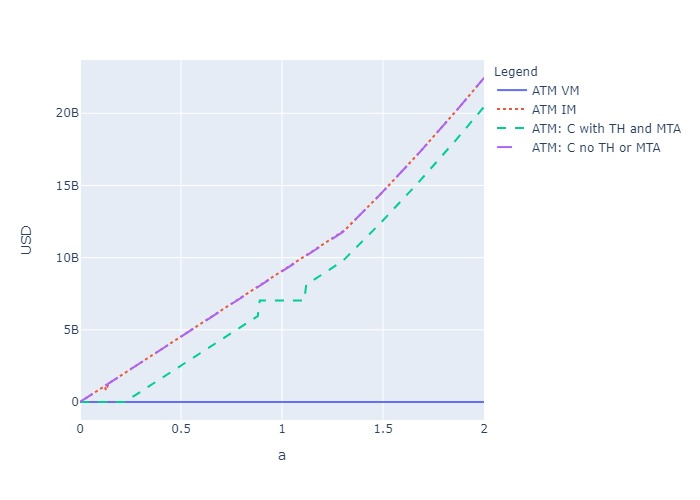

In [9]:
fig = px.line(resultDataframe[resultDataframe.Legend.str.startswith('ATM')], x='X', y='Y', color='Legend', line_dash='Legend')
fig.update_layout(xaxis_title = 'a', yaxis_title = 'USD')
exportPlotlyFigure(fig, 'C_and_its_components_for_ATM_IRS')
img_bytes = fig.to_image(format='jpeg')
Image(img_bytes)

Results are the same for the in the money IRS with the exception, that the VM is not 0 but VM is still a homogeneous function.

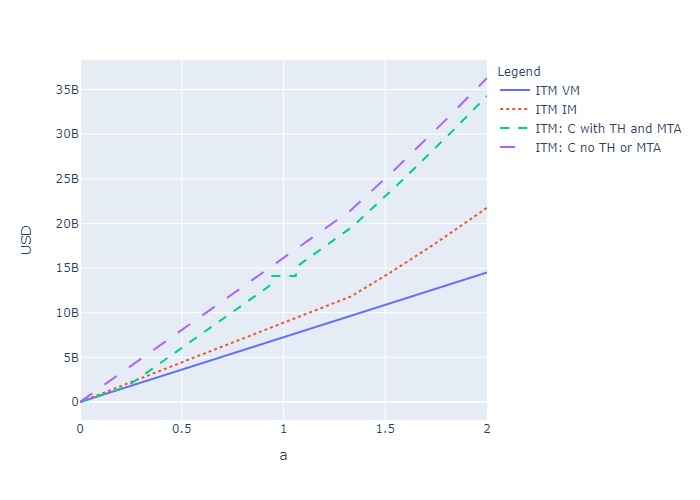

In [10]:
fig = px.line(resultDataframe[resultDataframe.Legend.str.startswith('ITM')], x='X', y='Y', color='Legend', line_dash='Legend')
fig.update_layout(xaxis_title = 'a', yaxis_title = 'USD')
exportPlotlyFigure(fig, 'C_and_its_components_for_ITM_IRS')
img_bytes = fig.to_image(format='jpeg')
Image(img_bytes)

In [12]:
export('C homogeneity for a single trade.ipynb')